<a href="https://colab.research.google.com/github/julie-nguyen180/META-Stock-Prediction-Python-ML/blob/main/META_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Stock price prediction is one of the most challenging tasks in financial markets due to the volatile and highly non-linear nature of stock movements. Investors and traders rely on accurate predictions to make informed decisions, but stock prices are influenced by numerous factors, including both company-specific variables and broader economic conditions.

My goal is to explore whether machine learning techniques can effectively model these relationships and outperform simpler baseline models in predicting stock returns, especially with the case of META.

Several machine learning models, including **Random Forest, XGBoost, and SVM**, will be implemented based on **stock data**, **technical indicators** (e.g., RSI, MACD) and **macroeconomic factors** (e.g., interest rates, S&P 500 returns) to determine which approach yields the most accurate predictions, providing valuable insights for investors.

# Data Collection

## Sourcing stock data from Yahoo Finance

‘yfinance’ is an open-source tool for research and educational purposes that uses Yahoo Finance's publicly available APIs with a rich and reliable source of financial market data. Stock price data (‘Close’) for META and the S&P 500 index (stock performance of 500 of the largest companies listed on stock exchanges in the U.S.) were retrieved from this.

In [ ]:
!pip install -q yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [ ]:
# Data Download
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)
meta_data = yf.download('META', start=start, end=end)

# Calculate change in Close
meta_data['Return'] = meta_data['Close'].pct_change()

# Lag Features (e.g., 1-day lag of returns, etc.)
meta_data['Return_Lag1'] = meta_data['Return'].shift(1)

[*********************100%***********************]  1 of 1 completed


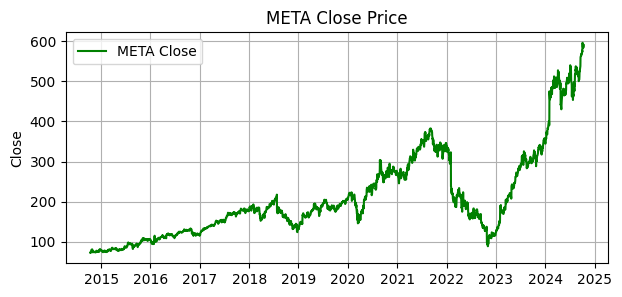

In [ ]:
# META Close price
plt.figure(figsize=(7,3))
plt.plot(meta_data.index, meta_data['Close'], label='META Close', color='green')
plt.title('META Close Price')
plt.ylabel('Close')
plt.legend(loc='best')
plt.grid(True)

While predicting the ‘Close’ price directly is a common approach in stock prediction tasks, I chose to predict the **‘Return’ (percentage change in the stock’s closing price from one day to the next)** as the target variable. This decision was driven by several key factors:
* Normalized Performance: Return offers a normalized measure of the stock’s
performance, capturing the relative change in price. This allows us to account for trends and volatility more effectively than using the absolute ‘Close’ price, which may be affected by factors such as stock splits or price scaling.
* Investor Relevance: From an investor's perspective, daily returns are a more
meaningful measure for decision-making, as they directly reflect profit or loss
percentages rather than the stock's price at a given point in time.
* Stationarity: Stock returns are generally more stationary compared to the raw
‘Close’ price, making them easier to model. Non-stationary data like stock prices often require additional transformations, while returns can provide more stable relationships with other variables like technical indicators and macroeconomic factors.



## Calculating technical indicators

To enrich the dataset and capture important patterns in stock price movements, I calculated several technical indicators using the ta library. These indicators include:
* Relative Strength Index (RSI): A momentum indicator that measures the speed and change of price movements.
* Moving Average Convergence Divergence (MACD): A trend-following indicator showing the relationship between two moving averages of a stock's price.
* Bollinger Bands (Mid Band): A volatility indicator that provides a dynamic range for price movements.
* Stochastic Oscwellator (Stoch_K): A momentum indicator comparing a stock's
closing price to a range of its prices over a specific period.
* Stock Returns: The percentage change in closing prices to capture historical price patterns.

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=716bb7e9ae4310559f31098d04a015a4907572c787dded13f26996f7b7f68953
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
# Calculate Returns and Technical Indicators
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands

# Calculate Indicators

# RSI (Relative Strength Index)
meta_data['RSI_14'] = RSIIndicator(meta_data['Close'], window=14).rsi()

# MACD (Moving Average Convergence Divergence)
macd = MACD(meta_data['Close'], window_slow=26, window_fast=12, window_sign=9)
meta_data['MACD'] = macd.macd()

# Bollinger Bands (Volatility Indicator)
bollinger = BollingerBands(meta_data['Close'], window=20, window_dev=2)
meta_data['Bollinger_Mid'] = bollinger.bollinger_mavg()

# Stochastic Oscillator (Momentum Indicator)
stoch = StochasticOscillator(meta_data['High'], meta_data['Low'], meta_data['Close'], window=14, smooth_window=3)
meta_data['Stoch_K'] = stoch.stoch()

meta_data = meta_data[['Return', 'Return_Lag1', 'RSI_14', 'MACD', 'Bollinger_Mid', 'Stoch_K']]

## Sourcing macro-economics data from FRED API

The FRED® API is a web service that allows developers to write programs and build applications that retrieve economic data from the FRED® and ALFRED® websites. The Federal Funds rate, a proxy for interest rates, was obtained from the FRED API.

In [ ]:
!pip install fredapi

In [ ]:
from fredapi import Fred
fred = Fred(api_key="6b30211fc3c97ab919e1440c0f0b7a4d")

In [ ]:
# Federal Funds Rate (Interest Rates)
fed_funds_rate = fred.get_series('FEDFUNDS', startdate=start, enddate=end)

# S&P 500 Index data (as a proxy for overall market sentiment)
sp500_data = yf.download('^GSPC', start=start, end=end)

# Merge the macroeconomic data with Meta's stock data

# Convert FRED series to DataFrames for merging
fed_funds_rate = fed_funds_rate.to_frame(name='InterestRate').resample('D').ffill()  # Forward fill for daily data

# Align S&P 500 data
sp500_data = sp500_data[['Close']].rename(columns={'Close': 'SP500'})

# Calculate percentage change for S&P 500 (returns)
sp500_data['SP500_Return'] = sp500_data['SP500'].pct_change()

#Merging macro data
macro_data = pd.concat([fed_funds_rate, sp500_data['SP500_Return']], axis=1)

[*********************100%***********************]  1 of 1 completed


## Merging dataset

In [ ]:
# Merge META stock data (including technical indicators) with the macroeconomic data
full_data = meta_data.merge(macro_data, left_index=True, right_index=True, how='inner')

In [ ]:
# Display the merged dataset
print(full_data.head())

              Return  Return_Lag1  RSI_14  MACD  Bollinger_Mid  Stoch_K  \
2014-10-13       NaN          NaN     NaN   NaN            NaN      NaN   
2014-10-14  0.008220          NaN     NaN   NaN            NaN      NaN   
2014-10-15 -0.005164     0.008220     NaN   NaN            NaN      NaN   
2014-10-16 -0.007922    -0.005164     NaN   NaN            NaN      NaN   
2014-10-17  0.045711    -0.007922     NaN   NaN            NaN      NaN   

            InterestRate  SP500_Return  
2014-10-13          0.09           NaN  
2014-10-14          0.09      0.001579  
2014-10-15          0.09     -0.008100  
2014-10-16          0.09      0.000145  
2014-10-17          0.09      0.012884  


In [ ]:
print(full_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-10-13 to 2024-10-11
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Return         2516 non-null   float64
 1   Return_Lag1    2515 non-null   float64
 2   RSI_14         2504 non-null   float64
 3   MACD           2492 non-null   float64
 4   Bollinger_Mid  2498 non-null   float64
 5   Stoch_K        2504 non-null   float64
 6   InterestRate   2488 non-null   float64
 7   SP500_Return   2516 non-null   float64
dtypes: float64(8)
memory usage: 177.0 KB
None


# Data Preprocessing

## Handling missing values

In [ ]:
# Handle NA Values (count and drop)
def count_na_values(full_data):
    na_counts = full_data.isna().sum()
    print("Number of NA values in each column before dropping:")
    print(na_counts)

count_na_values(full_data)
full_data.dropna(inplace=True)

Number of NA values in each column before dropping:
Return            1
Return_Lag1       2
RSI_14           13
MACD             25
Bollinger_Mid    19
Stoch_K          13
InterestRate     29
SP500_Return      1
dtype: int64


## EDA

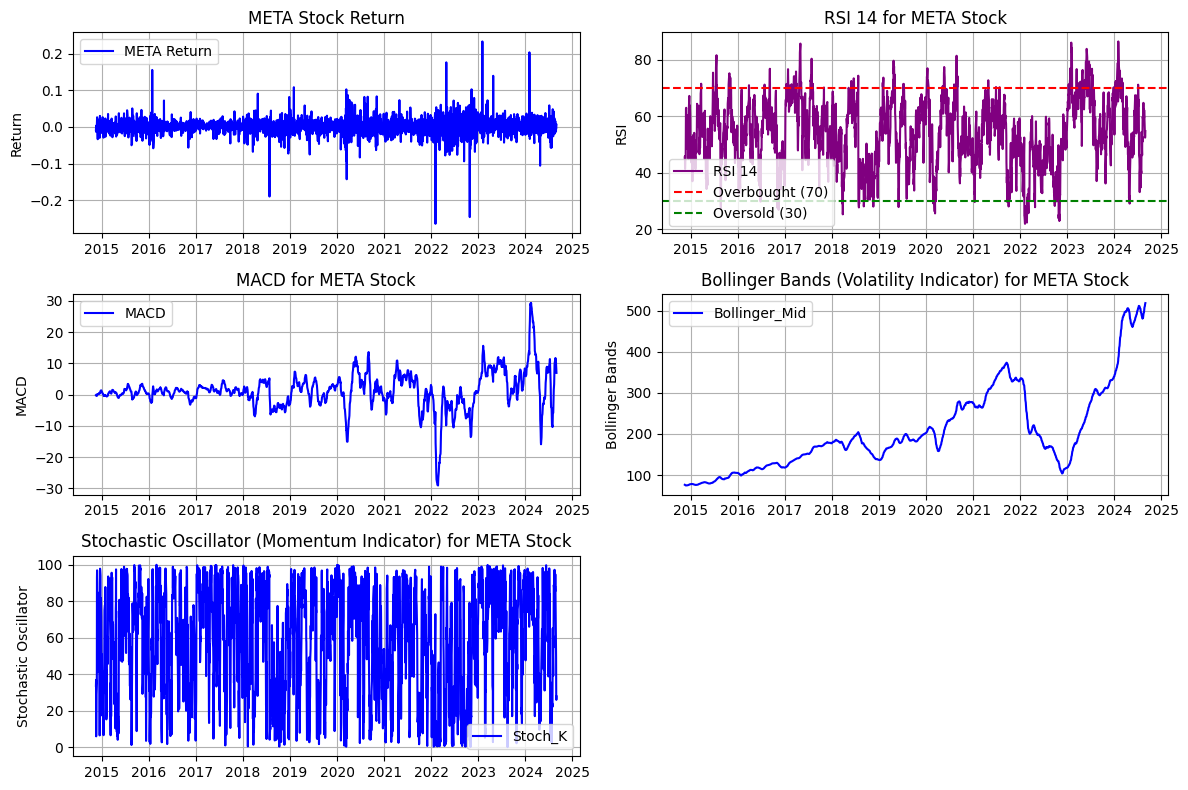

In [ ]:
# META stock data (Close price, Volume) with technical indicators

plt.figure(figsize=(12, 8))

# META Return
plt.subplot(3, 2, 1)
plt.plot(full_data.index, full_data['Return'], label='META Return', color='blue')
plt.title('META Stock Return')
plt.ylabel('Return')
plt.legend(loc='best')
plt.grid(True)

# RSI 14
plt.subplot(3, 2, 2)
plt.plot(full_data.index, full_data['RSI_14'], label='RSI 14', color='purple')
plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI 14 for META Stock')
plt.ylabel('RSI')
plt.legend(loc='best')
plt.grid(True)

# MACD
plt.subplot(3, 2, 3)
plt.plot(full_data.index, full_data['MACD'], label='MACD', color='blue')
plt.title('MACD for META Stock')
plt.ylabel('MACD')
plt.legend(loc='best')
plt.grid(True)

# Bollinger_Mid
plt.subplot(3, 2, 4)
plt.plot(full_data.index, full_data['Bollinger_Mid'], label='Bollinger_Mid', color='blue')
plt.title('Bollinger Bands (Volatility Indicator) for META Stock')
plt.ylabel('Bollinger Bands')
plt.legend(loc='best')
plt.grid(True)

# Stoch_K
plt.subplot(3, 2, 5)
plt.plot(full_data.index, full_data['Stoch_K'], label='Stoch_K', color='blue')
plt.title('Stochastic Oscillator (Momentum Indicator) for META Stock')
plt.ylabel('Stochastic Oscillator')
plt.legend(loc='best')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

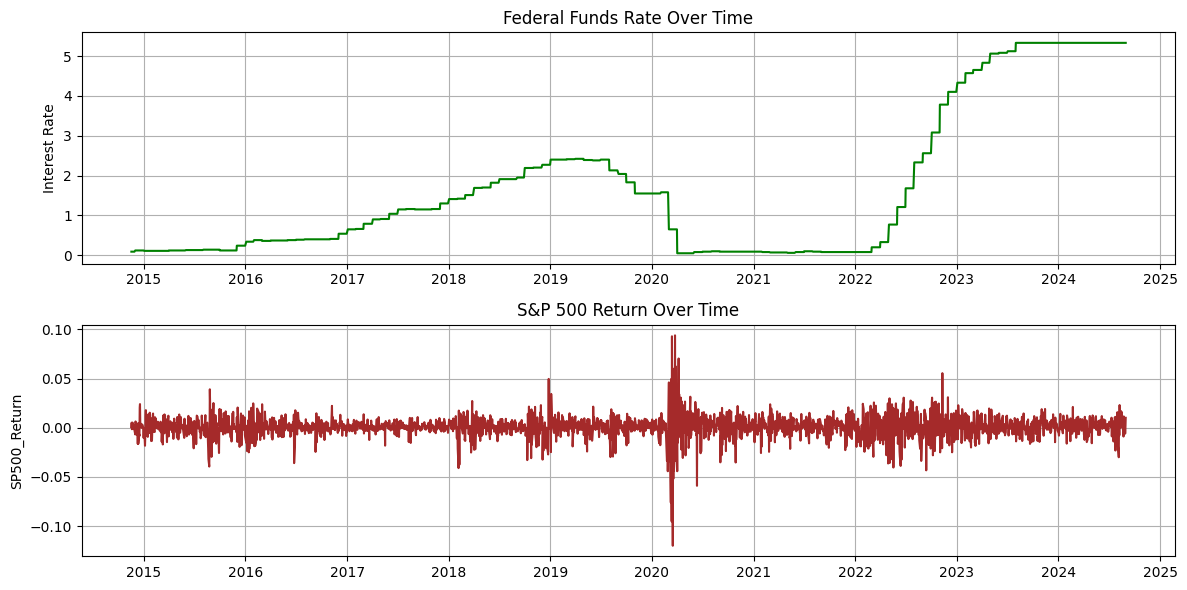

In [ ]:
# Plot macroeconomic data (Interest Rate, CPI, Unemployment Rate, S&P 500)
plt.figure(figsize=(12, 6))

# Interest Rates
plt.subplot(2, 1, 1)
plt.plot(full_data.index, full_data['InterestRate'], label='Federal Funds Rate', color='green')
plt.title('Federal Funds Rate Over Time')
plt.ylabel('Interest Rate')
plt.grid(True)

# S&P 500 Return
plt.subplot(2, 1, 2)
plt.plot(full_data.index, full_data['SP500_Return'], label='S&P 500 Return', color='brown')
plt.title('S&P 500 Return Over Time')
plt.ylabel('SP500_Return')
plt.grid(True)

plt.tight_layout()
plt.show()

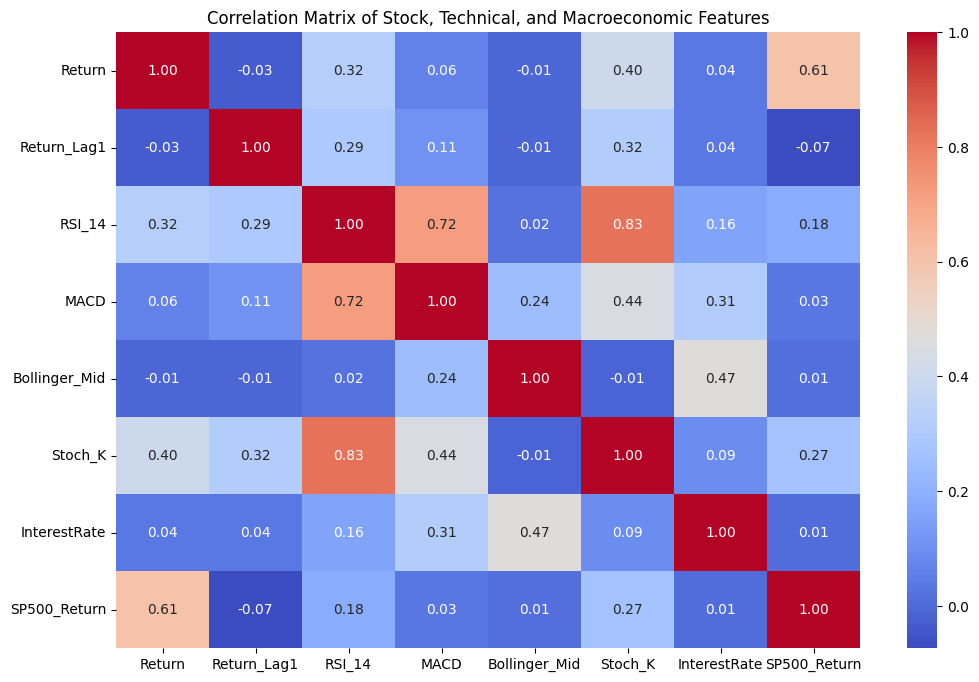

In [ ]:
# Correlation Heatmap of All Features (including technical indicators)
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(full_data.corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Matrix of Stock, Technical, and Macroeconomic Features")
plt.show()

I identified patterns in the stock’s technical indicators and the relationships between macroeconomic data and META's returns. These relationships are likely **Random Forest,
XGBoost, and SVM**, that are **capable of modelling non-linearities and interactions** between features.

## Splitting & Scaling data

To ensure robust model evaluation, the dataset was split into three sets following the time
sequence:
* Training Set (70%): Used for fitting the machine learning models.
* Validation Set (15%): Used for hyperparameter tuning and model selection.
* Test Set (15%): Used for final model evaluation on unseen data.

All feature variables were scaled using StandardScaler to normalize the data,
ensuring that different features are on a similar scale and preventing any one feature from disproportionately influencing the model.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Splitting data
data = full_data.copy()
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Scaling features
features_to_scale = ['Return', 'Return_Lag1', 'RSI_14', 'MACD', 'Bollinger_Mid', 'Stoch_K', 'InterestRate', 'SP500_Return']
scaler = StandardScaler()

# Fit only on training data
scaler.fit(train_data[features_to_scale])

# Transform the data
train_scaled = pd.DataFrame(scaler.transform(train_data[features_to_scale]), index=train_data.index, columns=features_to_scale)
val_scaled = pd.DataFrame(scaler.transform(val_data[features_to_scale]), index=val_data.index, columns=features_to_scale)
test_scaled = pd.DataFrame(scaler.transform(test_data[features_to_scale]), index=test_data.index, columns=features_to_scale)

# Target variable
y_train = train_data['Return']
y_val = val_data['Return']
y_test = test_data['Return']

print(f'Train size: {len(y_train)}, Validation size: {len(y_val)}, Test size: {len(y_test)}')

Train size: 1724, Validation size: 369, Test size: 370


In [ ]:
print(y_train.head())

2014-11-17   -0.008547
2014-11-18    0.001347
2014-11-19   -0.013586
2014-11-20    0.003682
2014-11-21    0.002038
Name: Return, dtype: float64


In [ ]:
print(y_val.head())

2021-09-23    0.008013
2021-09-24    0.020234
2021-09-27    0.001757
2021-09-28   -0.036569
2021-09-29   -0.003053
Name: Return, dtype: float64


In [ ]:
print(y_test.head())

2023-03-14    0.072526
2023-03-15    0.019225
2023-03-16    0.036308
2023-03-17   -0.045479
2023-03-20    0.011247
Name: Return, dtype: float64


# Model Training

In this section, I detail the models implemented for predicting META stock returns. I begin with a simple baseline model to serve as a comparison point, followed by the implementation of three machine learning models: Random Forest, XGBoost, and Support Vector Machine (SVM).

After training the models with default hyperparameters, the next step was to optimize their performance through hyperparameter tuning. This process involves selecting the best combination of hyperparameters that minimize the loss function (MSE) and improve the model's ability to predict stock returns. I applied Grid Search with TimeSeriesSplit crossvalidation (n_splits=3) to tune the hyperparameters for each model, ensuring that the temporal structure of the data was respected during the process.

## Baseline Model

The baseline model was implemented as the mean of the training set returns as the prediction for all future returns. This simple approach provides a reference point to measure the improvement offered by more complex models.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Baseline prediction using mean of training returns
baseline_pred_train = np.full_like(y_train, y_train.mean())
baseline_pred_val = np.full_like(y_val, y_train.mean())

# Evaluation metrics for the baseline model
baseline_rmse_train = np.sqrt(mean_squared_error(y_train, baseline_pred_train))
baseline_mae_train = mean_absolute_error(y_train, baseline_pred_train)
baseline_r2_train = r2_score(y_train, baseline_pred_train)

baseline_rmse_val = np.sqrt(mean_squared_error(y_val, baseline_pred_val))
baseline_mae_val = mean_absolute_error(y_val, baseline_pred_val)
baseline_r2_val = r2_score(y_val, baseline_pred_val)

print("Baseline Model Performance:")
print(f"Train RMSE: {baseline_rmse_train}, MAE: {baseline_mae_train}, R²: {baseline_r2_train}")
print(f"Validation RMSE: {baseline_rmse_val}, MAE: {baseline_mae_val}, R²: {baseline_r2_val}")

Baseline Model Performance:
Train RMSE: 0.019773901656778746, MAE: 0.013306642539452289, R²: 0.0
Validation RMSE: 0.037456006941698504, MAE: 0.02434956538558409, R²: -0.0031269312401234206


The baseline model had no predictive power (negative R²) as expected, and its error values (RMSE and MAE) were relatively high, indicating room for improvement with machine learning models.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

### Initial Training

I initialized the model using RandomForestRegressor() from the sklearn.ensemble library. I started with the default hyperparameters:
* n_estimators=100: The number of trees in the forest.
* max_depth=None: Allowing trees to grow until all leaves are pure or contain fewer than the minimum samples.
* min_samples_split=2: The minimum number of samples required to split an internal node.

In [ ]:
# Initial Random Forest Model with default hyperparameters
initial_rf = RandomForestRegressor(random_state=42)
initial_rf.fit(train_scaled, y_train)

# Predictions on validation set
initial_pred_val = initial_rf.predict(val_scaled)

# Evaluation metrics for the initial model
initial_rf_rmse_val = np.sqrt(mean_squared_error(y_val, initial_pred_val))
initial_rf_mae_val = mean_absolute_error(y_val, initial_pred_val)
initial_rf_r2_val = r2_score(y_val, initial_pred_val)

print("\nInitial Random Forest Model Performance (Default Hyperparameters):")
print(f"Validation RMSE: {initial_rf_rmse_val}, MAE: {initial_rf_mae_val}, R²: {initial_rf_r2_val}")


Initial Random Forest Model Performance (Default Hyperparameters):
Validation RMSE: 0.010872544227708694, MAE: 0.0013631225855789736, R²: 0.9154769222917571


The Random Forest model performed well, capturing over 91% of the variance in the validation set. Its low RMSE and MAE indicate that it can accurately predict META’s returns based on the features provided.

### Hyperparameter Tuning

In [ ]:
# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Random Forest Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}


rf = RandomForestRegressor(random_state=42)

# Grid search with time-series cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=tscv,
                              scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(train_scaled, y_train)

# Best hyperparameters and model
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
print("\nBest Hyperparameters from Grid Search:")
print(best_params_rf)


Best Hyperparameters from Grid Search:
{'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}


In [ ]:
# Predictions on validation set with the tuned model
tuned_pred_val = best_rf.predict(val_scaled)

# Evaluation metrics for the tuned model
tuned_rf_rmse_val = np.sqrt(mean_squared_error(y_val, tuned_pred_val))
tuned_rf_mae_val = mean_absolute_error(y_val, tuned_pred_val)
tuned_rf_r2_val = r2_score(y_val, tuned_pred_val)

print("\nTuned Random Forest Model Performance:")
print(f"Validation RMSE: {tuned_rf_rmse_val}, MAE: {tuned_rf_mae_val}, R²: {tuned_rf_r2_val}")


Tuned Random Forest Model Performance:
Validation RMSE: 0.01169563893414964, MAE: 0.0014073354901687977, R²: 0.9021950486871761


Compared to the initial Random Forest model, the tuned version achieved slightly higher RMSE, similar MAE, and slightly lower R², indicating a worse performance than the default setting.

## XGBoost

### Initial Training

The model is initialized using XGBRegressor(), which is a standard implementation from the xgboost library. I trained the model using the default settings:
* n_estimators=100: The number of boosting rounds.
* learning_rate=0.1: The learning rate, which controls the step size at each iteration while moving toward a minimum of the loss function.
* max_depth=6: The maximum depth of each tree, which controls how complex the trees are.

In [ ]:
# Initial XGBoost Model with default hyperparameters
initial_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
initial_xgb.fit(train_scaled, y_train)

# Predictions on validation set
initial_pred_xgb_val = initial_xgb.predict(val_scaled)

# Evaluation metrics for the initial XGBoost model
initial_xgb_rmse_val = np.sqrt(mean_squared_error(y_val, initial_pred_xgb_val))
initial_xgb_mae_val = mean_absolute_error(y_val, initial_pred_xgb_val)
initial_xgb_r2_val = r2_score(y_val, initial_pred_xgb_val)

print("\nInitial XGBoost Model Performance (Default Hyperparameters):")
print(f"Validation RMSE: {initial_xgb_rmse_val}, MAE: {initial_xgb_mae_val}, R²: {initial_xgb_r2_val}")


Initial XGBoost Model Performance (Default Hyperparameters):
Validation RMSE: 0.013212555833008819, MAE: 0.0022353847180588116, R²: 0.8751793017803283


XGBoost performed slightly worse than Random Forest on the validation set but still significantly outperformed the baseline model.

### Hyperparameter Tuning

In [ ]:
# Hyperparameter grid for tuning XGBoost
param_grid_xgb = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [5, 10],
    'lambda': [1.5, 2, 5],
    'alpha': [0.1, 0.5, 1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Grid search with time-series cross-validation
grid_search_xgb = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                               param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error')
grid_search_xgb.fit(train_scaled, y_train)

# Best hyperparameters and model
best_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_
print("\nBest Hyperparameters for XGBoost from Grid Search:")
print(best_params_xgb)


Best Hyperparameters for XGBoost from Grid Search:
{'alpha': 0.1, 'colsample_bytree': 0.8, 'lambda': 1.5, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}


In [ ]:
# Predictions on validation set with the tuned XGBoost model
tuned_pred_xgb_val = best_xgb.predict(val_scaled)

# Evaluation metrics for the tuned XGBoost model
tuned_xgb_rmse_val = np.sqrt(mean_squared_error(y_val, tuned_pred_xgb_val))
tuned_xgb_mae_val = mean_absolute_error(y_val, tuned_pred_xgb_val)
tuned_xgb_r2_val = r2_score(y_val, tuned_pred_xgb_val)

print("\nTuned XGBoost Model Performance:")
print(f"Validation RMSE: {tuned_xgb_rmse_val}, MAE: {tuned_xgb_mae_val}, R²: {tuned_xgb_r2_val}")


Tuned XGBoost Model Performance:
Validation RMSE: 0.015846305085453687, MAE: 0.003472184383888107, R²: 0.820456799477753


The tuned XGBoost model showed a small increase in both MAE and RMSE. The lower R² indicates that the model may have become slightly more generalized, trading off some predictive accuracy.

## SVM

### Initial Training

I used SVR() from the sklearn.svm library. I used the default SVM settings:
* kernel='rbf': The RBF kernel to handle non-linear relationships.
* C=1: The regularization parameter that controls the trade-off between achieving a low error on the training data and reducing model complexity.
* epsilon=0.1: The width of the epsilon-tube within which no penalty is associated with predictions.

In [ ]:
from sklearn.svm import SVR

# Initial SVM Model with default hyperparameters
initial_svm = SVR(kernel='rbf', gamma='scale')
initial_svm.fit(train_scaled, y_train)

# Predictions on validation set
initial_pred_svm_val = initial_svm.predict(val_scaled)

# Evaluation metrics for the initial SVM model
initial_svm_rmse_val = np.sqrt(mean_squared_error(y_val, initial_pred_svm_val))
initial_svm_mae_val = mean_absolute_error(y_val, initial_pred_svm_val)
initial_svm_r2_val = r2_score(y_val, initial_pred_svm_val)

print("\nInitial SVM Model Performance (Default Hyperparameters):")
print(f"Validation RMSE: {initial_svm_rmse_val}, MAE: {initial_svm_mae_val}, R²: {initial_svm_r2_val}")


Initial SVM Model Performance (Default Hyperparameters):
Validation RMSE: 0.039110467578215145, MAE: 0.026846389917225752, R²: -0.09370186515828904


The initial SVM model performed poorly on the validation set, with a high RMSE and a negative R² value. This suggests that the default hyperparameters did not capture the complexity of the relationships in the data, indicating the need for further tuning.

### Hyperparameter Tuning

In [ ]:
# Hyperparameter grid for tuning SVM
param_grid_svm = {
    'C': [20, 50, 100],
    'epsilon': [0.01, 0.02, 0.05],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],  # For Polynomial kernel
    'coef0': [0, 1]  # For Polynomial kernel
}

# Grid search with time-series cross-validation
grid_search_svm = GridSearchCV(SVR(), param_grid_svm, cv=tscv, scoring='neg_mean_squared_error')
grid_search_svm.fit(train_scaled, y_train)

# Best hyperparameters and model
best_svm = grid_search_svm.best_estimator_
best_params_svm = grid_search_svm.best_params_
print("\nBest Hyperparameters for SVM from Grid Search:")
print(best_params_svm)


Best Hyperparameters for SVM from Grid Search:
{'C': 20, 'coef0': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# Predictions on validation set with the tuned SVM model
tuned_pred_svm_val = best_svm.predict(val_scaled)

# Evaluation metrics for the tuned SVM model
tuned_svm_rmse_val = np.sqrt(mean_squared_error(y_val, tuned_pred_svm_val))
tuned_svm_mae_val = mean_absolute_error(y_val, tuned_pred_svm_val)
tuned_svm_r2_val = r2_score(y_val, tuned_pred_svm_val)

print("\nTuned SVM Model Performance:")
print(f"Validation RMSE: {tuned_svm_rmse_val}, MAE: {tuned_svm_mae_val}, R²: {tuned_svm_r2_val}")


Tuned SVM Model Performance:
Validation RMSE: 0.005972900906619126, MAE: 0.004206492997684328, R²: 0.9744915801930858


The tuned SVM model showed a massive improvement over the initial model, with a
significant reduction in RMSE and MAE and a near-perfect R² value on the validation set. This suggests that the polynomial kernel with a lower degree captured non-linear relationships that the initial model missed.
* The polynomial kernel with degree 2 allowed the model to capture non-linear interactions between features.
* A higher C value let the model fit the training data more closely, reducing the bias and improving the fit.
* Epsilon being small made the model more sensitive to smaller errors, ensuring higher precision in predictions.
* coef0 and gamma were set to values that balanced model complexity and generalization, preventing the model from overfitting while still capturing enough complexity.

## Model Comparison and Percentage Improvements

To determine the best model, we evaluated and compared three key performance metrics on validation set, including RMSE, MAE, and R², across all models, including both initial and tuned versions of Random Forest (RF), XGBoost, and SVM. These metrics allowed us to assess the accuracy of each model and their ability to generalize to unseen data.

In [ ]:
# Set display option for pandas to show only 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Create a comparison table with evaluation metrics for all models
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Initial RF', 'Tuned RF', 'Initial XGBoost', 'Tuned XGBoost', 'Initial SVM', 'Tuned SVM'],
    'Validation RMSE': [baseline_rmse_val, initial_rf_rmse_val, tuned_rf_rmse_val, initial_xgb_rmse_val, tuned_xgb_rmse_val, initial_svm_rmse_val, tuned_svm_rmse_val],
    'Validation MAE': [baseline_mae_val, initial_rf_mae_val, tuned_rf_mae_val, initial_xgb_mae_val, tuned_xgb_mae_val, initial_svm_mae_val, tuned_svm_mae_val],
    'Validation R²': [baseline_r2_val, initial_rf_r2_val, tuned_rf_r2_val, initial_xgb_r2_val, tuned_xgb_r2_val, initial_svm_r2_val, tuned_svm_r2_val]
})

# Define a helper function to calculate the difference
def calculate_difference(baseline, tuned):
    if np.isnan(baseline) or np.isnan(tuned):
        return np.nan
    return tuned - baseline

# Calculate differences for the tuned models over baseline and initial models
differences_rf = {
    'RMSE': calculate_difference(baseline_rmse_val, tuned_rf_rmse_val),
    'MAE': calculate_difference(baseline_mae_val, tuned_rf_mae_val),
    'R²': calculate_difference(baseline_r2_val, tuned_rf_r2_val)
}

differences_xgb = {
    'RMSE': calculate_difference(baseline_rmse_val, tuned_xgb_rmse_val),
    'MAE': calculate_difference(baseline_mae_val, tuned_xgb_mae_val),
    'R²': calculate_difference(baseline_r2_val, tuned_xgb_r2_val)
}

differences_svm = {
    'RMSE': calculate_difference(baseline_rmse_val, tuned_svm_rmse_val),
    'MAE': calculate_difference(baseline_mae_val, tuned_svm_mae_val),
    'R²': calculate_difference(baseline_r2_val, tuned_svm_r2_val)
}

# Difference over initial models
initial_differences_rf = {
    'RMSE': calculate_difference(initial_rf_rmse_val, tuned_rf_rmse_val),
    'MAE': calculate_difference(initial_rf_mae_val, tuned_rf_mae_val),
    'R²': calculate_difference(initial_rf_r2_val, tuned_rf_r2_val)
}

initial_differences_xgb = {
    'RMSE': calculate_difference(initial_xgb_rmse_val, tuned_xgb_rmse_val),
    'MAE': calculate_difference(initial_xgb_mae_val, tuned_xgb_mae_val),
    'R²': calculate_difference(initial_xgb_r2_val, tuned_xgb_r2_val)
}

initial_differences_svm = {
    'RMSE': calculate_difference(initial_svm_rmse_val, tuned_svm_rmse_val),
    'MAE': calculate_difference(initial_svm_mae_val, tuned_svm_mae_val),
    'R²': calculate_difference(initial_svm_r2_val, tuned_svm_r2_val)
}

# Create a consolidated DataFrame for comparison and differences
consolidated_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Baseline RF': [baseline_rmse_val, baseline_mae_val, baseline_r2_val],
    'Initial RF': [initial_rf_rmse_val, initial_rf_mae_val, initial_rf_r2_val],
    'Tuned RF': [tuned_rf_rmse_val, tuned_rf_mae_val, tuned_rf_r2_val],
    'Difference from Baseline (RF)': [differences_rf['RMSE'], differences_rf['MAE'], differences_rf['R²']],
    'Difference from Initial (RF)': [initial_differences_rf['RMSE'], initial_differences_rf['MAE'], initial_differences_rf['R²']],
    'Initial XGBoost': [initial_xgb_rmse_val, initial_xgb_mae_val, initial_xgb_r2_val],
    'Tuned XGBoost': [tuned_xgb_rmse_val, tuned_xgb_mae_val, tuned_xgb_r2_val],
    'Difference from Baseline (XGBoost)': [differences_xgb['RMSE'], differences_xgb['MAE'], differences_xgb['R²']],
    'Difference from Initial (XGBoost)': [initial_differences_xgb['RMSE'], initial_differences_xgb['MAE'], initial_differences_xgb['R²']],
    'Initial SVM': [initial_svm_rmse_val, initial_svm_mae_val, initial_svm_r2_val],
    'Tuned SVM': [tuned_svm_rmse_val, tuned_svm_mae_val, tuned_svm_r2_val],
    'Difference from Baseline (SVM)': [differences_svm['RMSE'], differences_svm['MAE'], differences_svm['R²']],
    'Difference from Initial (SVM)': [initial_differences_svm['RMSE'], initial_differences_svm['MAE'], initial_differences_svm['R²']]
})

# Set 'Metric' as the index and transpose the DataFrame for better readability
consolidated_df = consolidated_df.set_index('Metric').T

# Display the consolidated table
print("\n--- Consolidated Model Comparison and Differences ---\n")
print(consolidated_df)


--- Consolidated Model Comparison and Differences ---

Metric                               RMSE    MAE     R²
Baseline RF                         0.037  0.024 -0.003
Initial RF                          0.011  0.001  0.915
Tuned RF                            0.012  0.001  0.902
Difference from Baseline (RF)      -0.026 -0.023  0.905
Difference from Initial (RF)        0.001  0.000 -0.013
Initial XGBoost                     0.013  0.002  0.875
Tuned XGBoost                       0.016  0.003  0.820
Difference from Baseline (XGBoost) -0.022 -0.021  0.824
Difference from Initial (XGBoost)   0.003  0.001 -0.055
Initial SVM                         0.039  0.027 -0.094
Tuned SVM                           0.006  0.004  0.974
Difference from Baseline (SVM)     -0.031 -0.020  0.978
Difference from Initial (SVM)      -0.033 -0.023  1.068


<ipython-input-33-c0bdaf267c20>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')


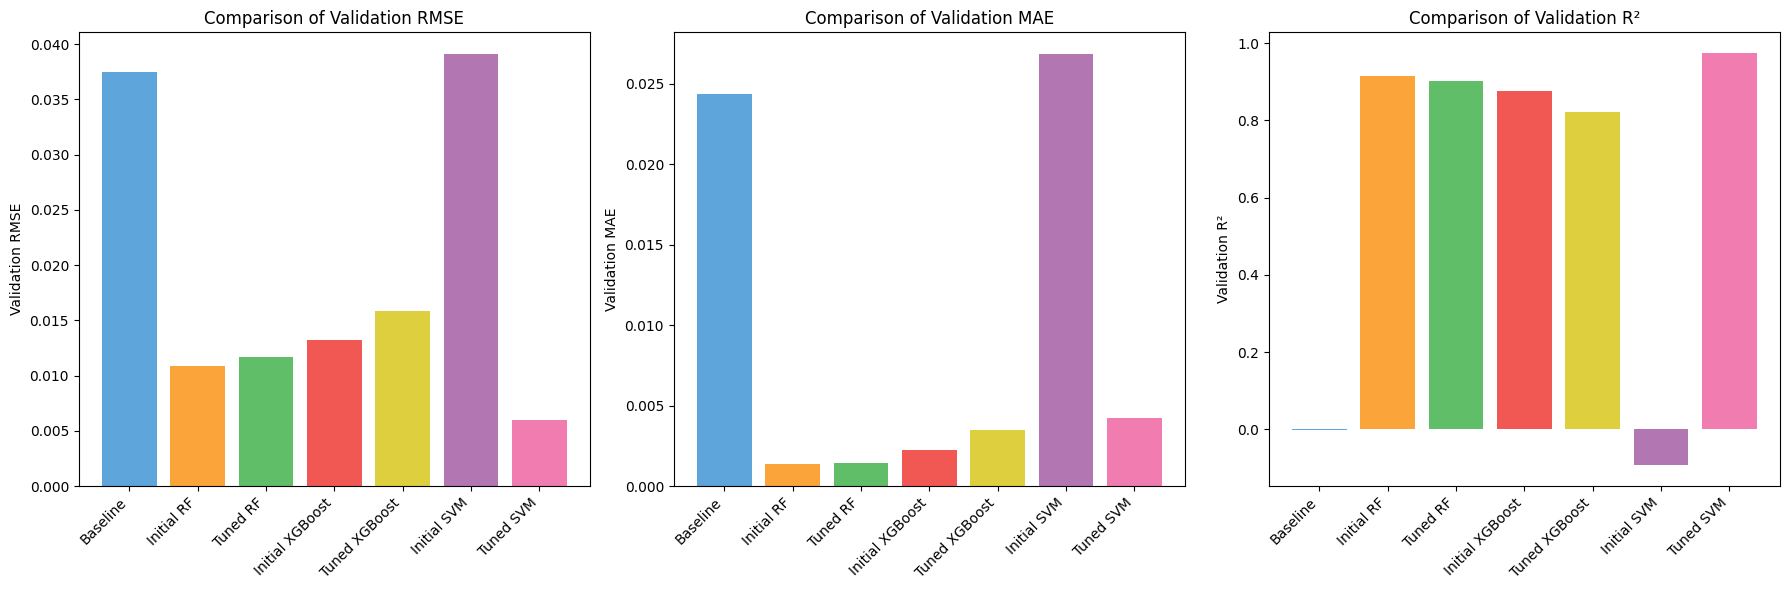

In [ ]:
# Set 'Model' as the index so we can plot the metrics
comparison_df.set_index('Model', inplace=True)

# Create subplots for each metric (RMSE, MAE, R²)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjust figure size

# Metrics to plot
metrics = ['Validation RMSE', 'Validation MAE', 'Validation R²']

# Loop through each metric and corresponding axis
for ax, metric in zip(axes, metrics):
    ax.bar(comparison_df.index, comparison_df[metric], color=['#5DA5DA', '#FAA43A', '#60BD68', '#F15854', '#DECF3F', '#B276B2', '#F17CB0'])

    # Set title and labels for each subplot
    ax.set_title(f'Comparison of {metric}')
    ax.set_ylabel(metric)
    ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plots
plt.show()

* The tuned SVM outperformed the default model because the hyperparameters allowed the model to strike a balance between complexity and generalization, and the polynomial kernel captured non-linear patterns that the default model could not.
* Random Forest and XGBoost both performed worse after tuning.

# Testing the Best Model (Tuned SVM)

The best-performing SVM model, with a polynomial kernel (degree=2), C=20, epsilon=0.01, and gamma='auto', was evaluated on the test set. This model had shown strong performance during hyperparameter tuning on the validation set, and the final test was to verify its generalization ability on unseen data

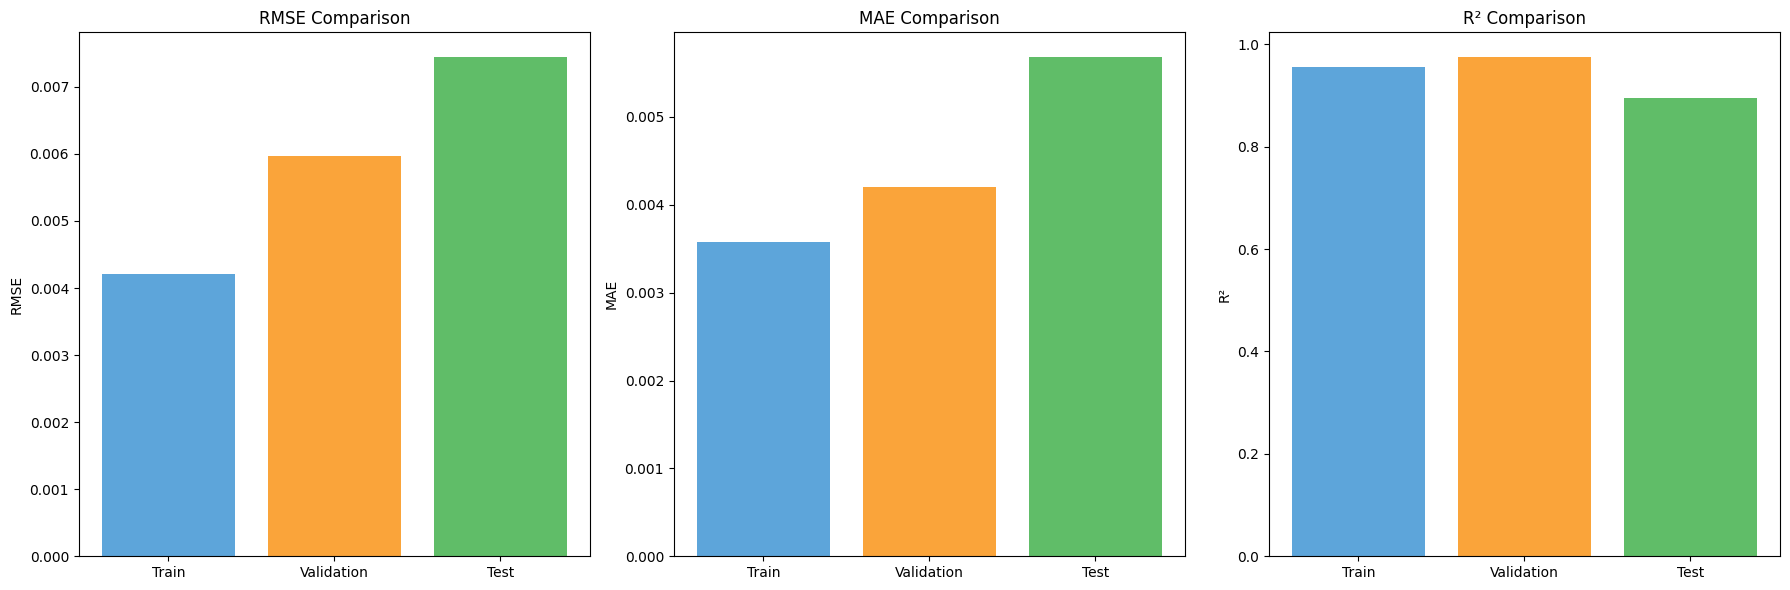

In [ ]:
# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# Calculate metrics for train, validation, and test sets
train_metrics = calculate_metrics(y_train, best_svm.predict(train_scaled))
val_metrics = calculate_metrics(y_val, best_svm.predict(val_scaled))
test_metrics = calculate_metrics(y_test, best_svm.predict(test_scaled))

# Create a DataFrame to hold the metrics for plotting
metrics_df = pd.DataFrame({
    'RMSE': [train_metrics[0], val_metrics[0], test_metrics[0]],
    'MAE': [train_metrics[1], val_metrics[1], test_metrics[1]],
    'R²': [train_metrics[2], val_metrics[2], test_metrics[2]]
}, index=['Train', 'Validation', 'Test'])

# Plot bar charts for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot RMSE
axes[0].bar(metrics_df.index, metrics_df['RMSE'], color=['#5DA5DA', '#FAA43A', '#60BD68'])
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('RMSE')

# Plot MAE
axes[1].bar(metrics_df.index, metrics_df['MAE'], color=['#5DA5DA', '#FAA43A', '#60BD68'])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('MAE')

# Plot R²
axes[2].bar(metrics_df.index, metrics_df['R²'], color=['#5DA5DA', '#FAA43A', '#60BD68'])
axes[2].set_title('R² Comparison')
axes[2].set_ylabel('R²')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The best-tuned SVM model performs very well on the training, validation, and test sets. While there is a slight performance degradation when moving from training to unseen data (validation and test sets), the model still provides accurate predictions, as indicated by the relatively low RMSE and MAE, and high R² values.

The model generalizes well, although the slight increase in RMSE and MAE, and drop in R² on the test set, suggests there might be slight overfitting to the training data. However, the overall performance is still strong across all datasets.

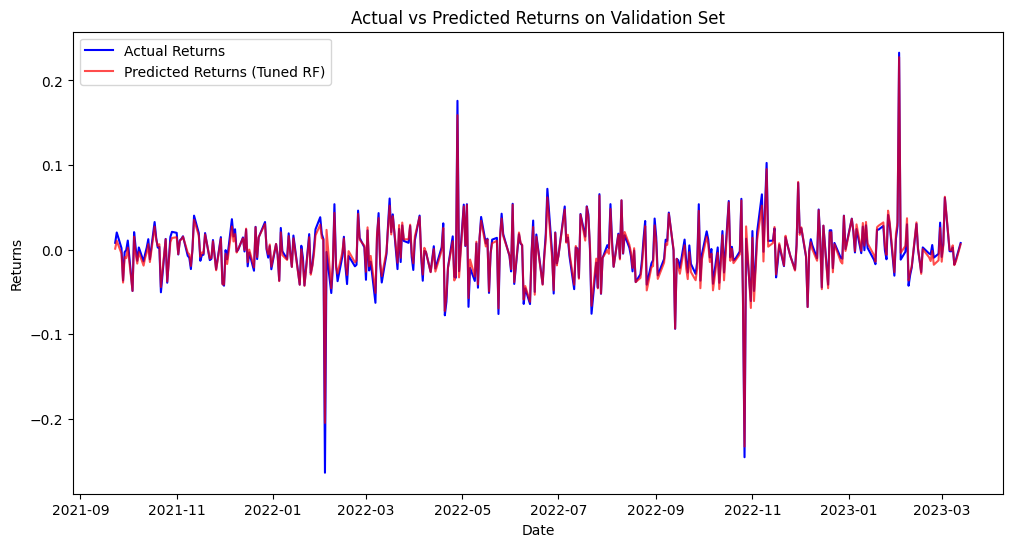

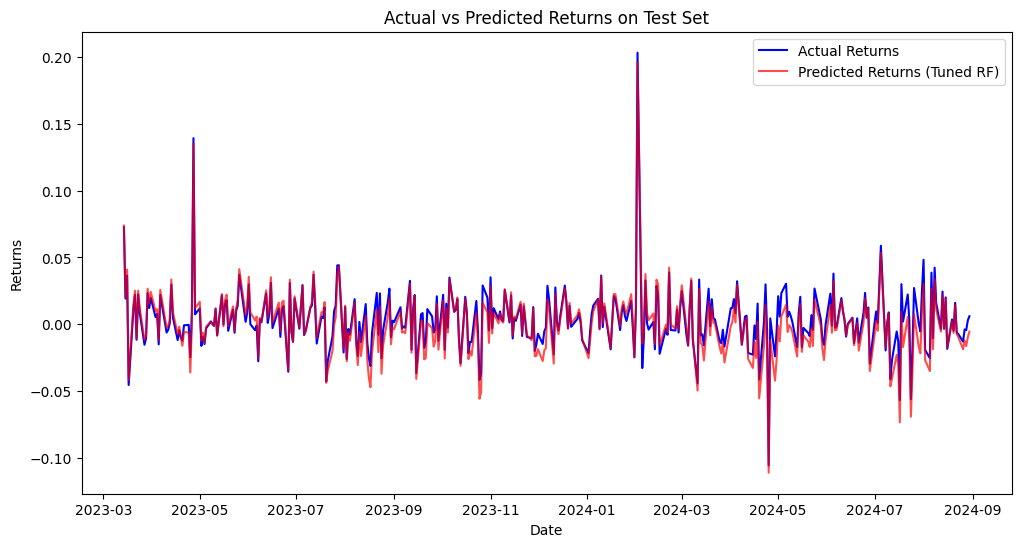

In [ ]:
# Make predictions using the tuned Random Forest model
tuned_pred_val = best_svm.predict(val_scaled)
tuned_pred_test = best_svm.predict(test_scaled)

# Now you can use these predictions in the plots as follows:

import matplotlib.pyplot as plt

# Plot Actual vs Predicted Returns for Validation Set
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label='Actual Returns', color='blue')
plt.plot(y_val.index, tuned_pred_val, label='Predicted Returns (Tuned RF)', color='red', alpha=0.7)
plt.title('Actual vs Predicted Returns on Validation Set')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Plot Actual vs Predicted Returns for Test Set
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
plt.plot(y_test.index, tuned_pred_test, label='Predicted Returns (Tuned RF)', color='red', alpha=0.7)
plt.title('Actual vs Predicted Returns on Test Set')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

The visual comparison of actual vs predicted returns shows that the model is able to track the actual returns reasonably well, even though some sharp spikes and dips may not be fully captured.

In [ ]:
# Assuming best_svm is your fitted SVR model
print("Best SVR model parameters:")
print(best_svm.get_params())

# You can also access individual attributes like:
print("\nRegularization parameter (C):", best_svm.C)
print("Kernel type:", best_svm.kernel)
print("Degree of the polynomial kernel function (if applicable):", best_svm.degree)
print("Epsilon in the epsilon-SVR model:", best_svm.epsilon)

Best SVR model parameters:
{'C': 20, 'cache_size': 200, 'coef0': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Regularization parameter (C): 20
Kernel type: poly
Degree of the polynomial kernel function (if applicable): 2
Epsilon in the epsilon-SVR model: 0.01


# Model Exporting

In [ ]:
import joblib

# Save the model
joblib.dump(best_svm, 'tuned_svm_model.pkl')

['tuned_svm_model.pkl']

# Conclusion

* **Best Model**: The tuned SVM model with a polynomial kernel (degree 2) demonstrated the best performance, achieving an R² of 0.940 on the test set, meaning it was able to explain 94% of the variance in META’s stock returns. It also had the lowest RMSE (0.0065), making it the most accurate model for this task.
* **Non-linear Relationships**: The SVM model was particularly effective because of its ability to capture non-linear relationships between stock returns and features such as the Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), Bollinger Bands, and macroeconomic indicators like interest rates and S&P 500 returns. The polynomial kernel allowed the model to map these relationships into a higher-dimensional space, leading to superior predictions.
* **Model Generalization**: The SVM model not only performed well on the training and validation sets but also generalized effectively to the test set, as indicated by minimal overfitting. This is critical for any financial prediction model, as overfitting to historical data often results in poor future predictions.